# Singular Spectrum Analysis (SSA).

Following the book "Singular Spectrum Analysis for Time Series" by N. Golyandina and A. Zhigljavsky.



Load the following packages:

In [ ]:
import numpy as np
import pandas as pd  #pd.show_versions()
import matplotlib.pylab as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta  
import pickle
import warnings
import math
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define functions:

In [ ]:
# Function for column times row matrix multiplication, returns a rank-one matrix (or 0).
# Parameters: 
#    c: column (np.array)
#    r: row (np.array) 
def c_r_mul(c,r):
    A = np.zeros([len(c), len(r)])
    for j in range(0,len(c)):
        for  k in range(0,len(r)):
            A[j,k] = c[j] * r[k]
    return A

#w-product between two time series x,y, see p.38
def w_prod(x, y, L):
    N = len(x)
    K = N - L + 1
    Ls = min(L, K)
    Ks = max(L, K)
    result = 0
    for j in range(1,N+1):
        if j < Ls:
            w = j
        elif j <= Ks:
            w = Ls
        else:
            w = N-j+1
        result = result + w*x[j-1]*y[j-1]
    return result

# w-correlation between two time series
def w_corr(x, y, L):
    return w_prod(x,y,L)/np.sqrt(w_prod(x,x,L)*w_prod(y,y,L))

# Returns eigenvalues and -vectors of the lagged covariance matrix and the elementary series.
# Parameters: 
#    x: time series
#    L: lag parameter
def w_correlation_matrix(d, x_el_series, L):
    matrix = np.zeros([d,d])
    for k in range(0,d):
        for j in range(0,d): 
            matrix[j,k] = w_corr(x_el_series[j],x_el_series[k],L)
    return matrix

# Returns eigenvalues and -vectors of the lagged covariance matrix and the elementary series.
# Parameters: 
#    x: time series
#    L: lag parameter
def SSA(x, L):
    K = N - L + 1
    Ls = min(L, K)
    Ks = max(L, K)
    X = np.zeros([L,K]) # trajectory matrix
    for j in range(0,L):
        for k in range(0,K):
           X[j,k] = x[j+k]
    S = np.matmul(X, np.transpose(X))   # lagged covariance matrix
    [eig_val, eig_vec] = np.linalg.eig(S / (N) ) # eigenvalues and -vectors; eig_vec[:,0] is the first eigenvector
    # convert into real numbers
    eig_val = np.real(eig_val)
    eig_vec = np.real(eig_vec)
    # sort such that eig_val[0] is the largest eigenvalue 
    idx = eig_val.argsort()[::-1]   
    eig_val = eig_val[idx]
    eig_vec = eig_vec[:,idx]
    d = np.linalg.matrix_rank(S) # TODO

    X_el = [] # elementary matrices

    for j in range(0,d):
        temp = c_r_mul(eig_vec[:,j], eig_vec[:,j])
        X_el.append(np.matmul(temp, X))
### X can be econstructed as X_rec:
#X_rec = np.zeros(X.shape)
#for j in range(0,d):
#    X_rec = X_rec + X_el[j]
#print(np.sum((np.abs(X-X_rec))))  # should be small

# construct decomposed time series
    x_el_series = [] # series corrsponding to the elementary matrices

    if L<K: 
      for j in range(0,d):
        M = X_el[j]
        temp = np.zeros(N)
        for k in range(1,N+1):
            if k < Ls:
                for j in range(0,k):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / (k)
            elif k <= Ks:
                for j in range(0,Ls):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / Ls
            else:
                for j in range(k-Ks, N-Ks+1):
                    temp[k-1] = temp[k-1] + M[j,k-j-1]
                temp[k-1] = temp[k-1] / (N-k+1)

        x_el_series.append(temp)
    else: 
      for j in range(0,d):
        M = X_el[j]
        temp = np.zeros(N)
        for k in range(1,N+1):
            if k < Ls:
                for j in range(0,k):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / (k)
            elif k <= Ks:
                for j in range(0,Ls):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / Ls
            else:
                for j in range(k-Ks, N-Ks+1):
                    temp[k-1] = temp[k-1] + M[k-j-1,j]
                temp[k-1] = temp[k-1] / (N-k+1)

        x_el_series.append(temp) 

    return [d, eig_val, eig_vec, x_el_series, X_el]

def eigen_value_grouping(d, x_el_series, L, n_clusters, eig_val = None):
    X = w_correlation_matrix(d, x_el_series, L)
    X = 1 - X # distance matrix (similarity matrix)
   # print(X)
    if not (eig_val is None):
        for j in range(0,d):
            for k in range(0,d):
                X[j,k] = X[j,k] * max(1, (pow(eig_val[min(j,k)] - eig_val[max(j,k)], 0.5))) #pow((eig_val[min(j,k)] - eig_val[max(j,k)]), 0.17)
   # print(X)
    embedding = MDS(n_components=L) # embed into R^L
    X_transformed = embedding.fit_transform(X)
  #  plt.scatter(X_transformed[1:,0], X_transformed[1:,1])
 #   plt.title("2-dimensional embedding of the eigenvalues")
  #  plt.show()

 #   print(X_transformed[0,0])
 #   print(X_transformed[0,1])
   # if not (eig_val is None):
    #    print(eig_val[0])

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_transformed)
    eig_val_clusters = kmeans.predict(X_transformed)

   # clustering = DBSCAN(eps=5, min_samples=1).fit(X)
   # print(clustering.labels_)
   # print(eig_val_clusters)

    silhouette_avg = silhouette_score(X_transformed, eig_val_clusters)

    plt.scatter(X_transformed[3:,0], X_transformed[3:,1], c=eig_val_clusters[3:], s=50, cmap='viridis')
    centers = kmeans.cluster_centers_
 #   plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5)
    plt.title("Clustered eigenvalues")
    plt.show()
    return silhouette_avg, eig_val_clusters

def check_free(A,B):
  X = A
  Y = B
  N = X.shape[0]
  p1 = np.trace(X) / N
  p2 = np.trace(Y) / N
  for j in range(0,N):
      X[j,j]  = X[j,j] - p1
      Y[j,j]  = Y[j,j] - p2
 # print("Tr(X)/N: " + str(np.trace(X) / N))
 # print("Tr(Y)/N: " + str(np.trace(Y) / N))
  mul = np.matmul(X,Y)
  mul = np.matmul(mul,mul)
  print("Tr(XYXY)/N (normalized X,Y): " + str(np.trace(mul) / N))
  print("Tr(XX)/N*Tr(YY)/N (normalized X,Y): " + str( np.trace(np.matmul(X,X))/N * np.trace(np.matmul(Y,Y))/N))
  print("\n")


Test for check_free:

In [ ]:
N=100
matrix = np.zeros([N,N], dtype=complex)
matrix2 = np.zeros([N,N], dtype=complex)
for k in range(0, N):
    matrix[k,k]= np.random.normal(loc=0, scale=1/(np.sqrt(2*N)))
    for k in range(0, N):
      for j in range(0, N):
        if j < k:
          ww = np.random.normal(loc=0, scale=1/(np.sqrt(2*N)))
          p  = np.random.normal(loc=0, scale=1/(np.sqrt(2*N)))
          matrix[j,k]= ww + 1j *p
          matrix[k,j] = ww - 1j *p

for k in range(0, N):
    matrix2[k,k]= np.random.normal(loc=0, scale=1/(np.sqrt(2*N)))
    for k in range(0, N):
      for j in range(0, N):
        if j < k:
          ww = np.random.normal(loc=0, scale=1/(np.sqrt(2*N)))
          p  = np.random.normal(loc=0, scale=1/(np.sqrt(2*N)))
          matrix2[j,k]= ww + 1j *p
          matrix2[k,j] = ww - 1j *p

check_free(matrix,matrix2)

Tr(X)/N: (5.551115123125783e-19+0j)
Tr(Y)/N: (-1.6653345369377347e-18+0j)
Tr(XYXY)/N (normalized X,Y): (0.011980401762113067+6.106226635438361e-18j)
Tr(XX)/N*Tr(YY)/N (normalized X,Y): (0.9969232356314203+0j)


# Example 1: sum of sine and square

Construct a time series as the sum of two series:

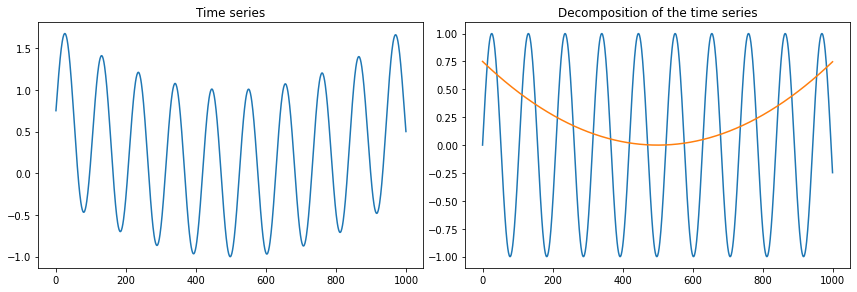

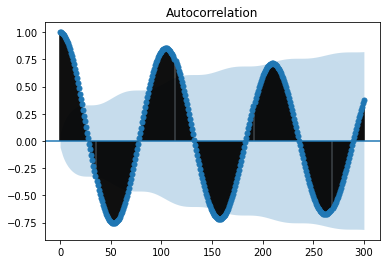

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


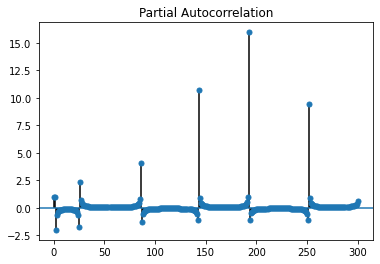

In [ ]:
# We construct a time series x as the sum of two structured time series x1 and x2.
N = 1000  # number of points
x = np.zeros(N)
x1 = np.zeros(N)
x2 = np.zeros(N)

for j in range(0,len(x1)):
    x1[j] = np.sin(j/(N/60))
    x2[j] = 3*(j/N-0.5)**2#3* j/ len(x1) 
    x[j] = x1[j] + x2[j]

#x2[0]=0.5
#x1[0]=0
#for j in range(1,len(x1)):
 #   x1[j] = np.sin(j/(N/30))
  #  x2[j] = 0.8*x2[j-1]+np.random.normal(0,0.2)
  #  x[j] = x1[j] + x2[j]

### Normalization
#m = np.average(x)
#std = np.std(x) 
#x = (x - m)/std
#x1 = (x1 - m)/std
#x2 = (x2 - m)/std

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.tight_layout()

axs[0].plot(x)
axs[0].set_title('Time series')
axs[1].plot(x1)
axs[1].plot(x2)
axs[1].set_title('Decomposition of the time series')
plt.show()

from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

plot_acf(x, lags = 300)
pyplot.show()

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(x, lags = 300)
pyplot.show()

# SSA:

Rank of S (lagged covariance matrix of size ([100, 100]): 5


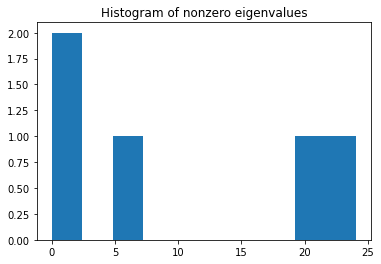

The largest eigenvalues: [2.40706080e+01 2.11518992e+01 6.69277444e+00 5.69173448e-02
 1.18319956e-05]


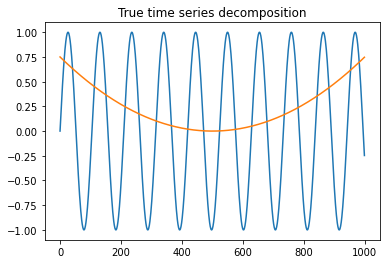

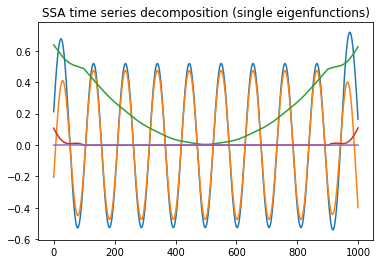

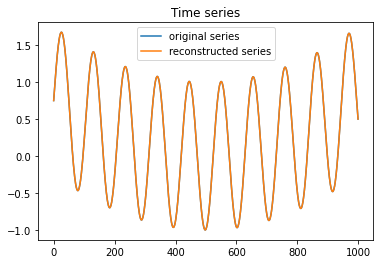

Difference between x and its reconstuction: sum = 1.4078269799933096e-12, average = 1.4078269799933097e-15


In [ ]:
L = 100  # Lag paramter
[d, eig_val, eig_vec, x_el_series, X_el] = SSA(x, L)

print("Rank of S (lagged covariance matrix of size ([" + str(L) + ", " + str(L) + "]): " + str(d))

plt.hist(eig_val[0:d], bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of nonzero eigenvalues")
plt.show()

print("The largest eigenvalues: " + str(np.real(eig_val[:min(10,d)])))

plt.plot(x1)
plt.plot(x2)

plt.title('True time series decomposition')
plt.show()

for j in range(0,d):
    plt.plot(x_el_series[j])
plt.title('SSA time series decomposition (single eigenfunctions)')
plt.show()

x_recons = np.zeros(N)
for j in range(0,d):
    x_recons = x_recons + +x_el_series[j]
plt.plot(x, label = 'original series')
plt.plot(x_recons, label = 'reconstructed series')
plt.legend()
plt.title('Time series')
plt.show()

print("Difference between x and its reconstuction: sum = " + str(np.sum((np.abs(x-x_recons)))) + ", average = " + str(np.average((np.abs(x-x_recons)))))  # should be small


We look at the w-correleation matrix:

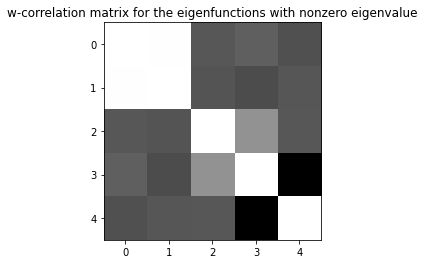

In [ ]:
w_corr_matrix = w_correlation_matrix(d, x_el_series, L)
plt.imshow(w_corr_matrix, interpolation='nearest', cmap=cm.Greys_r)
plt.title("w-correlation matrix for the eigenfunctions with nonzero eigenvalue")
plt.show()

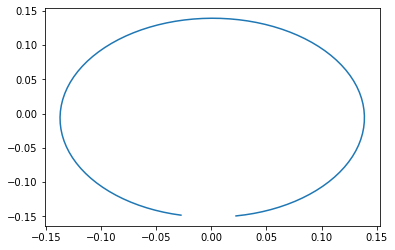

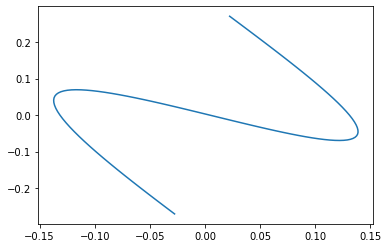

In [ ]:
# scatter plots of eigenvectors

plt.plot(eig_vec[:,0],eig_vec[:,1])
plt.show()
plt.plot(eig_vec[:,0],eig_vec[:,3])
plt.show()

# Eigentriple grouping: manually
We are looking for two groups of (non-zero) eigenvalues $\lambda_1, ..., \lambda_k$ and $\lambda_{k+1}, ...., \lambda_m$ that correspond to $x_1$ and $x_2$. 


This can be done by looking at the so called w-correlation matrix.

We only earch for two groups by using the k-means formula (TODO, primitive search).

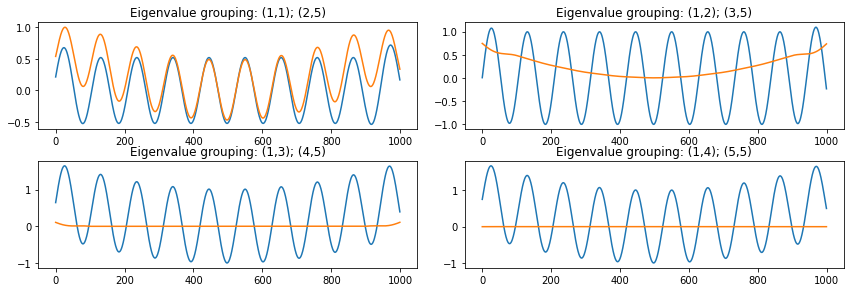

In [ ]:
fig, axs = plt.subplots(nrows=int(d/2), ncols=2, figsize=(12, 4))
fig.tight_layout()
for k in range(1,d):
    x_c_1 = np.zeros(x.shape)
    x_c_2 = np.zeros(x.shape)
    for j in range(0,k):
        x_c_1 = x_c_1 + x_el_series[j]
    for j in range(k,d):
        x_c_2 = x_c_2 + x_el_series[j]
    if int(d/2) > 1:
        axs[int((k-1-(k-1)%2)/2),(k-1)%2].plot(x_c_1)
        axs[int((k-1-(k-1)%2)/2),(k-1)%2].plot(x_c_2)
        axs[int((k-1-(k-1)%2)/2),(k-1)%2].set_title("Eigenvalue grouping: (1," + str(k) + "); " + "(" + str(k+1) +"," + str(d) + ")")
    else:
        axs[(k-1)%2].plot(x_c_1)
        axs[(k-1)%2].plot(x_c_2)
        axs[(k-1)%2].set_title("Eigenvalue grouping: (1," + str(k) + "); " + "(" + str(k+1) +"," + str(d) + ")")

plt.show()



# Free independence of matrices?

In [ ]:
X= X_el[0]
S = np.matmul(X, np.transpose(X)) 

#print(np.array(S).shape)
#check_free(matrix,matrix2)


for j in range(1,5):
  X = np.zeros([100,100])
  Y = np.zeros([100,100])
  for k in range(0,j):
      X = X + np.matmul(X_el[k], np.transpose(X_el[k]))
  for k in range(j,5):
      Y = Y + np.matmul(X_el[k], np.transpose(X_el[k]))
  check_free(X,Y)
  check_free(X,X)



Tr(XYXY)/N (normalized X,Y): 722703707684.3599
Tr(XX)/N*Tr(YY)/N (normalized X,Y): 27786016230704.613


Tr(XYXY)/N (normalized X,Y): 3224701107699140.5
Tr(XX)/N*Tr(YY)/N (normalized X,Y): 32901722112976.914


Tr(XYXY)/N (normalized X,Y): 135596360656.42865
Tr(XX)/N*Tr(YY)/N (normalized X,Y): 4462228309496.353


Tr(XYXY)/N (normalized X,Y): 4947683100280982.0
Tr(XX)/N*Tr(YY)/N (normalized X,Y): 101273279395452.42


Tr(XYXY)/N (normalized X,Y): 11942217.936752148
Tr(XX)/N*Tr(YY)/N (normalized X,Y): 335033772.6053298


Tr(XYXY)/N (normalized X,Y): 4903488526708176.0
Tr(XX)/N*Tr(YY)/N (normalized X,Y): 109126912790088.88


Tr(XYXY)/N (normalized X,Y): 0.5168194285482159
Tr(XX)/N*Tr(YY)/N (normalized X,Y): 14.477510582877501


Tr(XYXY)/N (normalized X,Y): 4902985841555222.0
Tr(XX)/N*Tr(YY)/N (normalized X,Y): 109115236049850.9




#Example 2: stock prices

In [ ]:
!pip install yfinance

800

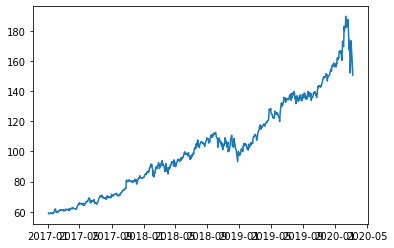

In [ ]:
import yfinance as yf

#define the ticker symbol
tickerSymbol = 'MSFT'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2017-1-1', end='2020-3-10')

#see your data
x = tickerDf['Open']

plt.plot(tickerDf['Open'])

len(x)

In [ ]:
# Import package
import yfinance as yf

# Get the data
data = yf.download(tickers="MSFT", period="5d", interval="1m")

# Print the data
print(data.tail())

[*********************100%***********************]  1 of 1 completed
                                 Open        High  ...   Adj Close   Volume
Datetime                                           ...                     
2020-06-05 15:59:00-04:00  186.960007  187.589996  ...  187.250000   935539
2020-06-08 09:30:00-04:00  185.524994  185.960007  ...  185.865005  1332905
2020-06-08 09:31:00-04:00  185.839996  186.070007  ...  185.919998   172086
2020-06-08 09:32:00-04:00  185.880005  185.889999  ...  185.229996   261454
2020-06-08 09:33:17-04:00  185.330002  185.330002  ...  185.330002        0

[5 rows x 6 columns]


Rank of S (lagged covariance matrix of size ([100, 100]): 100


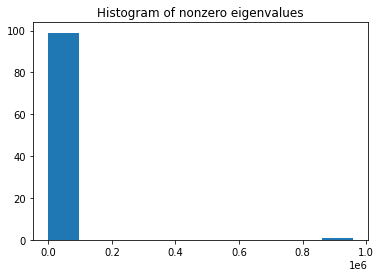

The largest eigenvalues: [9.57577770e+05 6.88265026e+02 1.52074908e+02 5.19211725e+01
 4.38138928e+01 3.64225571e+01 3.33024504e+01 2.50713118e+01
 2.07797310e+01 1.51773164e+01]


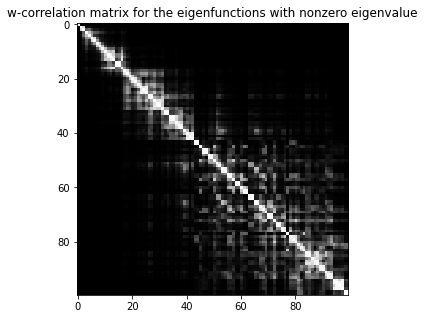

In [ ]:
x = np.array(tickerDf['Open'])
N = len(x)
L = 100  # Lag paramter

[d, eig_val, eig_vec, x_el_series, X_el] = SSA(x, L) 

print("Rank of S (lagged covariance matrix of size ([" + str(L) + ", " + str(L) + "]): " + str(d))

plt.hist(eig_val[0:d], bins=10)  # arguments are passed to np.histogram
plt.title("Histogram of nonzero eigenvalues")
plt.show()

print("The largest eigenvalues: " + str(np.real(eig_val[:min(10,d)])))

w_corr_matrix = w_correlation_matrix(d, x_el_series, L)
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.imshow(w_corr_matrix, interpolation='nearest', cmap=cm.Greys_r)
plt.title("w-correlation matrix for the eigenfunctions with nonzero eigenvalue")
plt.show()


In [ ]:
w_corr_matrix[40:46,40:46]

array([[1.        , 0.78247202, 0.90127999, 0.02803305, 0.02687843,
        0.01539561],
       [0.78247202, 1.        , 0.8941556 , 0.0052132 , 0.01245151,
        0.00276665],
       [0.90127999, 0.8941556 , 1.        , 0.08732985, 0.09238458,
        0.01315154],
       [0.02803305, 0.0052132 , 0.08732985, 1.        , 0.99735938,
        0.02529392],
       [0.02687843, 0.01245151, 0.09238458, 0.99735938, 1.        ,
        0.03940951],
       [0.01539561, 0.00276665, 0.01315154, 0.02529392, 0.03940951,
        1.        ]])

Manually: We guess an eigentriple grouping from the w-correlation matrix.

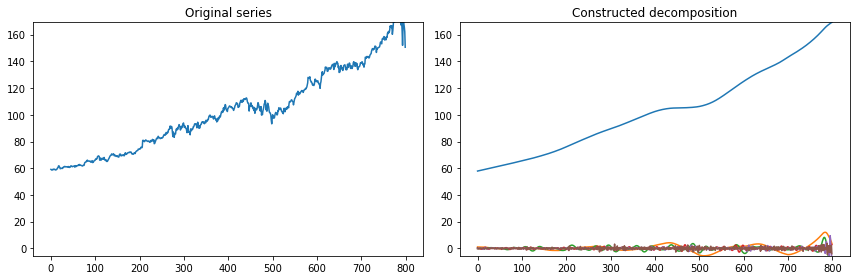

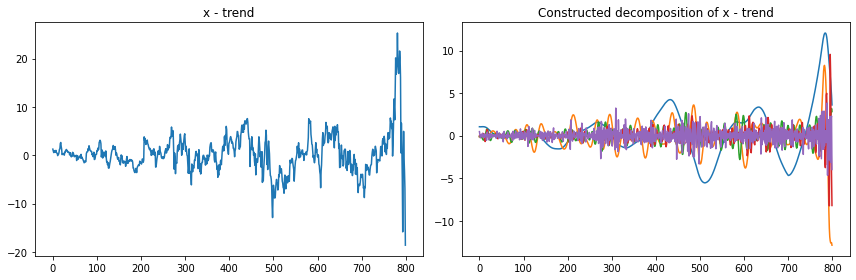

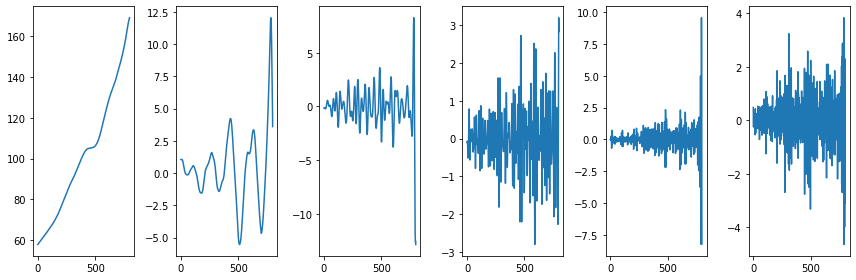

In [ ]:
# We take six groups.
x1_rec = np.zeros(x.shape)
x2_rec = np.zeros(x.shape)
x3_rec = np.zeros(x.shape)
x4_rec = np.zeros(x.shape)
x5_rec = np.zeros(x.shape)
x6_rec = np.zeros(x.shape)
for j in range(0,1):
        x1_rec = x1_rec + x_el_series[j]
for j in range(1,3):
        x2_rec = x2_rec + x_el_series[j]
for j in range(3,9):
        x3_rec = x3_rec + x_el_series[j]
for j in range(9,16):
        x4_rec = x4_rec + x_el_series[j]
for j in range(16,32):
        x5_rec = x5_rec + x_el_series[j]
for j in range(32,d):
        x6_rec = x6_rec + x_el_series[j]

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
fig.tight_layout()

axs[0].plot(x)
#axs[0].plot(x1_rec+x2_rec+x3_rec+x4_rec+x5_rec+x6_rec)
axs[0].set_title('Original series')

axs[1].plot(x1_rec)
axs[1].plot(x2_rec)
axs[1].plot(x3_rec)
axs[1].plot(x4_rec)
axs[1].plot(x5_rec)
axs[1].plot(x6_rec)
axs[1].set_title('Constructed decomposition')
fig.tight_layout()

axs[0].set_ylim(min(min(x1_rec),min(x2_rec)), max(max(x1_rec),max(x2_rec)))
axs[1].set_ylim(min(min(x1_rec),min(x2_rec)), max(max(x1_rec),max(x2_rec)))
plt.show()

fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(x-x1_rec)
axs[0].set_title("x - trend")
#axs[1].plot(x1_rec)
axs[1].plot(x2_rec)
axs[1].plot(x3_rec)
axs[1].plot(x4_rec)
axs[1].plot(x5_rec)
axs[1].plot(x6_rec)
axs[1].set_title("Constructed decomposition of x - trend")
fig.tight_layout()
plt.show()


fig, axs = plt.subplots(ncols=6, figsize=(12, 4))
axs[0].plot(x1_rec)
axs[1].plot(x2_rec)
axs[2].plot(x3_rec)
axs[3].plot(x4_rec)
axs[4].plot(x5_rec)
axs[5].plot(x6_rec)
fig.tight_layout()
plt.show()

[[0.         0.98536254 0.99259798 ... 0.99999983 0.99999985 0.99999982]
 [0.98536254 0.         0.23980471 ... 0.99998386 0.99999482 0.99999312]
 [0.99259798 0.23980471 0.         ... 0.99989684 0.9999855  0.9999784 ]
 ...
 [0.99999983 0.99998386 0.99989684 ... 0.         0.80519707 0.79249751]
 [0.99999985 0.99999482 0.9999855  ... 0.80519707 0.         0.00338449]
 [0.99999982 0.99999312 0.9999784  ... 0.79249751 0.00338449 0.        ]]
[[0.00000000e+00 9.63888826e+02 9.71238581e+02 ... 9.78558697e+02
  9.78558769e+02 9.78558742e+02]
 [9.63888826e+02 0.00000000e+00 5.55286486e+00 ... 2.62283855e+01
  2.62304880e+01 2.62304945e+01]
 [9.71238581e+02 5.55286486e+00 0.00000000e+00 ... 1.23178321e+01
  1.23227880e+01 1.23228092e+01]
 ...
 [9.78558697e+02 2.62283855e+01 1.23178321e+01 ... 0.00000000e+00
  8.05197073e-01 7.92497506e-01]
 [9.78558769e+02 2.62304880e+01 1.23227880e+01 ... 8.05197073e-01
  0.00000000e+00 3.38449407e-03]
 [9.78558742e+02 2.62304945e+01 1.23228092e+01 ... 7.924

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


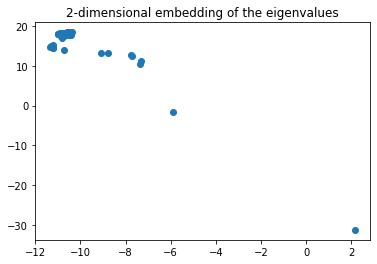

1024.9497035511213
-1653.5830361513258
957577.7700292636


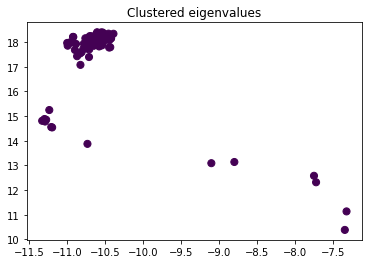

n_clusters: 2; Sil. score: 0.988235662452405
[[0.         0.98536254 0.99259798 ... 0.99999983 0.99999985 0.99999982]
 [0.98536254 0.         0.23980471 ... 0.99998386 0.99999482 0.99999312]
 [0.99259798 0.23980471 0.         ... 0.99989684 0.9999855  0.9999784 ]
 ...
 [0.99999983 0.99998386 0.99989684 ... 0.         0.80519707 0.79249751]
 [0.99999985 0.99999482 0.9999855  ... 0.80519707 0.         0.00338449]
 [0.99999982 0.99999312 0.9999784  ... 0.79249751 0.00338449 0.        ]]
[[0.00000000e+00 9.63888826e+02 9.71238581e+02 ... 9.78558697e+02
  9.78558769e+02 9.78558742e+02]
 [9.63888826e+02 0.00000000e+00 5.55286486e+00 ... 2.62283855e+01
  2.62304880e+01 2.62304945e+01]
 [9.71238581e+02 5.55286486e+00 0.00000000e+00 ... 1.23178321e+01
  1.23227880e+01 1.23228092e+01]
 ...
 [9.78558697e+02 2.62283855e+01 1.23178321e+01 ... 0.00000000e+00
  8.05197073e-01 7.92497506e-01]
 [9.78558769e+02 2.62304880e+01 1.23227880e+01 ... 8.05197073e-01
  0.00000000e+00 3.38449407e-03]
 [9.7855874

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


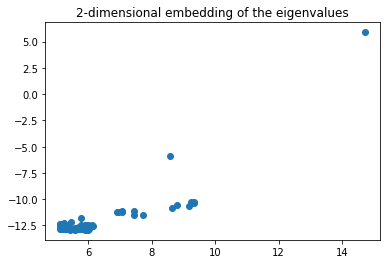

-609.3110245546502
1205.118892806707
957577.7700292636


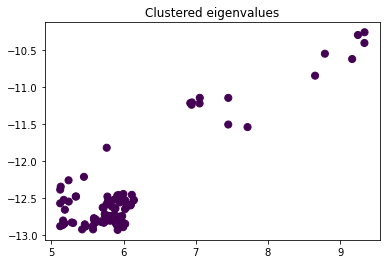

n_clusters: 3; Sil. score: 0.9066282383749054
[[0.         0.98536254 0.99259798 ... 0.99999983 0.99999985 0.99999982]
 [0.98536254 0.         0.23980471 ... 0.99998386 0.99999482 0.99999312]
 [0.99259798 0.23980471 0.         ... 0.99989684 0.9999855  0.9999784 ]
 ...
 [0.99999983 0.99998386 0.99989684 ... 0.         0.80519707 0.79249751]
 [0.99999985 0.99999482 0.9999855  ... 0.80519707 0.         0.00338449]
 [0.99999982 0.99999312 0.9999784  ... 0.79249751 0.00338449 0.        ]]
[[0.00000000e+00 9.63888826e+02 9.71238581e+02 ... 9.78558697e+02
  9.78558769e+02 9.78558742e+02]
 [9.63888826e+02 0.00000000e+00 5.55286486e+00 ... 2.62283855e+01
  2.62304880e+01 2.62304945e+01]
 [9.71238581e+02 5.55286486e+00 0.00000000e+00 ... 1.23178321e+01
  1.23227880e+01 1.23228092e+01]
 ...
 [9.78558697e+02 2.62283855e+01 1.23178321e+01 ... 0.00000000e+00
  8.05197073e-01 7.92497506e-01]
 [9.78558769e+02 2.62304880e+01 1.23227880e+01 ... 8.05197073e-01
  0.00000000e+00 3.38449407e-03]
 [9.785587

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


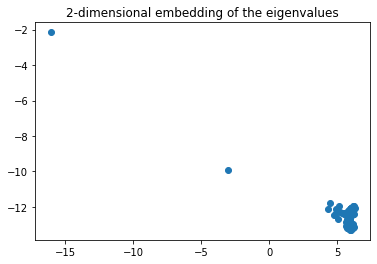

-551.1162531520796
1219.2395574573393
957577.7700292636


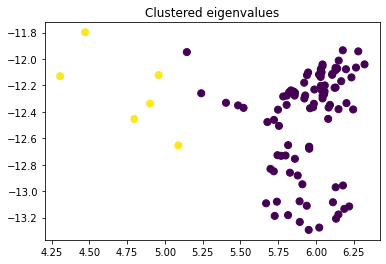

n_clusters: 4; Sil. score: 0.8165517945751065
[[0.         0.98536254 0.99259798 ... 0.99999983 0.99999985 0.99999982]
 [0.98536254 0.         0.23980471 ... 0.99998386 0.99999482 0.99999312]
 [0.99259798 0.23980471 0.         ... 0.99989684 0.9999855  0.9999784 ]
 ...
 [0.99999983 0.99998386 0.99989684 ... 0.         0.80519707 0.79249751]
 [0.99999985 0.99999482 0.9999855  ... 0.80519707 0.         0.00338449]
 [0.99999982 0.99999312 0.9999784  ... 0.79249751 0.00338449 0.        ]]
[[0.00000000e+00 9.63888826e+02 9.71238581e+02 ... 9.78558697e+02
  9.78558769e+02 9.78558742e+02]
 [9.63888826e+02 0.00000000e+00 5.55286486e+00 ... 2.62283855e+01
  2.62304880e+01 2.62304945e+01]
 [9.71238581e+02 5.55286486e+00 0.00000000e+00 ... 1.23178321e+01
  1.23227880e+01 1.23228092e+01]
 ...
 [9.78558697e+02 2.62283855e+01 1.23178321e+01 ... 0.00000000e+00
  8.05197073e-01 7.92497506e-01]
 [9.78558769e+02 2.62304880e+01 1.23227880e+01 ... 8.05197073e-01
  0.00000000e+00 3.38449407e-03]
 [9.785587

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


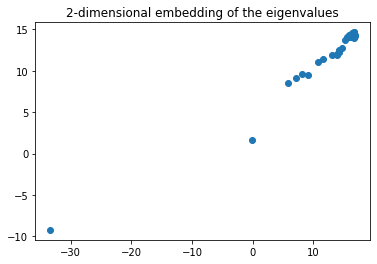

-1495.681283686809
-1333.38433592919
957577.7700292636


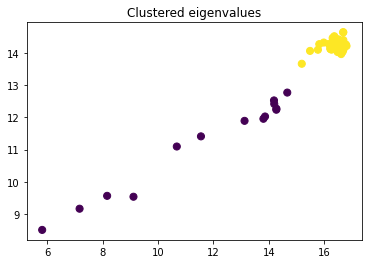

n_clusters: 5; Sil. score: 0.7811644105679306
[[0.         0.98536254 0.99259798 ... 0.99999983 0.99999985 0.99999982]
 [0.98536254 0.         0.23980471 ... 0.99998386 0.99999482 0.99999312]
 [0.99259798 0.23980471 0.         ... 0.99989684 0.9999855  0.9999784 ]
 ...
 [0.99999983 0.99998386 0.99989684 ... 0.         0.80519707 0.79249751]
 [0.99999985 0.99999482 0.9999855  ... 0.80519707 0.         0.00338449]
 [0.99999982 0.99999312 0.9999784  ... 0.79249751 0.00338449 0.        ]]
[[0.00000000e+00 9.63888826e+02 9.71238581e+02 ... 9.78558697e+02
  9.78558769e+02 9.78558742e+02]
 [9.63888826e+02 0.00000000e+00 5.55286486e+00 ... 2.62283855e+01
  2.62304880e+01 2.62304945e+01]
 [9.71238581e+02 5.55286486e+00 0.00000000e+00 ... 1.23178321e+01
  1.23227880e+01 1.23228092e+01]
 ...
 [9.78558697e+02 2.62283855e+01 1.23178321e+01 ... 0.00000000e+00
  8.05197073e-01 7.92497506e-01]
 [9.78558769e+02 2.62304880e+01 1.23227880e+01 ... 8.05197073e-01
  0.00000000e+00 3.38449407e-03]
 [9.785587

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


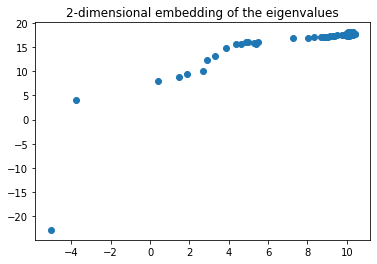

-865.0841974007728
-1627.7555451999413
957577.7700292636


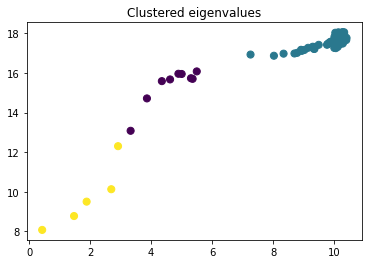

n_clusters: 6; Sil. score: 0.7748062403947154
[[0.         0.98536254 0.99259798 ... 0.99999983 0.99999985 0.99999982]
 [0.98536254 0.         0.23980471 ... 0.99998386 0.99999482 0.99999312]
 [0.99259798 0.23980471 0.         ... 0.99989684 0.9999855  0.9999784 ]
 ...
 [0.99999983 0.99998386 0.99989684 ... 0.         0.80519707 0.79249751]
 [0.99999985 0.99999482 0.9999855  ... 0.80519707 0.         0.00338449]
 [0.99999982 0.99999312 0.9999784  ... 0.79249751 0.00338449 0.        ]]
[[0.00000000e+00 9.63888826e+02 9.71238581e+02 ... 9.78558697e+02
  9.78558769e+02 9.78558742e+02]
 [9.63888826e+02 0.00000000e+00 5.55286486e+00 ... 2.62283855e+01
  2.62304880e+01 2.62304945e+01]
 [9.71238581e+02 5.55286486e+00 0.00000000e+00 ... 1.23178321e+01
  1.23227880e+01 1.23228092e+01]
 ...
 [9.78558697e+02 2.62283855e+01 1.23178321e+01 ... 0.00000000e+00
  8.05197073e-01 7.92497506e-01]
 [9.78558769e+02 2.62304880e+01 1.23227880e+01 ... 8.05197073e-01
  0.00000000e+00 3.38449407e-03]
 [9.785587

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


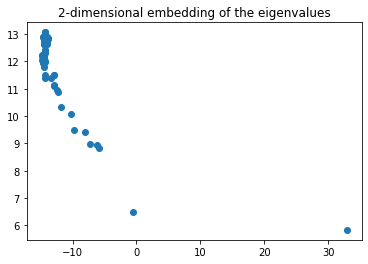

1305.1242784180972
-1203.6280016887495
957577.7700292636


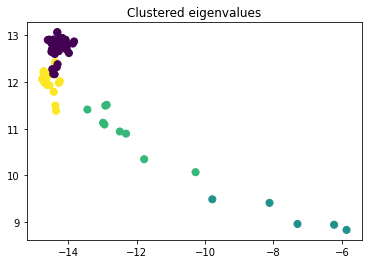

n_clusters: 7; Sil. score: 0.5511572431874103
n_clusters_max: 2
All silhouette_avg scores: [0.988235662452405, 0.9066282383749054, 0.8165517945751065, 0.7811644105679306, 0.7748062403947154, 0.5511572431874103]
[[0.         0.98536254 0.99259798 ... 0.99999983 0.99999985 0.99999982]
 [0.98536254 0.         0.23980471 ... 0.99998386 0.99999482 0.99999312]
 [0.99259798 0.23980471 0.         ... 0.99989684 0.9999855  0.9999784 ]
 ...
 [0.99999983 0.99998386 0.99989684 ... 0.         0.80519707 0.79249751]
 [0.99999985 0.99999482 0.9999855  ... 0.80519707 0.         0.00338449]
 [0.99999982 0.99999312 0.9999784  ... 0.79249751 0.00338449 0.        ]]
[[0.00000000e+00 9.63888826e+02 9.71238581e+02 ... 9.78558697e+02
  9.78558769e+02 9.78558742e+02]
 [9.63888826e+02 0.00000000e+00 5.55286486e+00 ... 2.62283855e+01
  2.62304880e+01 2.62304945e+01]
 [9.71238581e+02 5.55286486e+00 0.00000000e+00 ... 1.23178321e+01
  1.23227880e+01 1.23228092e+01]
 ...
 [9.78558697e+02 2.62283855e+01 1.23178321e

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


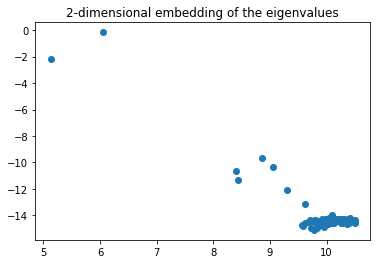

-982.4743874440787
1386.0435934949162
957577.7700292636


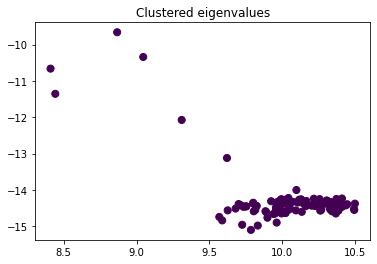

n_clusters: 2; Sil. score: 0.9882357038325553


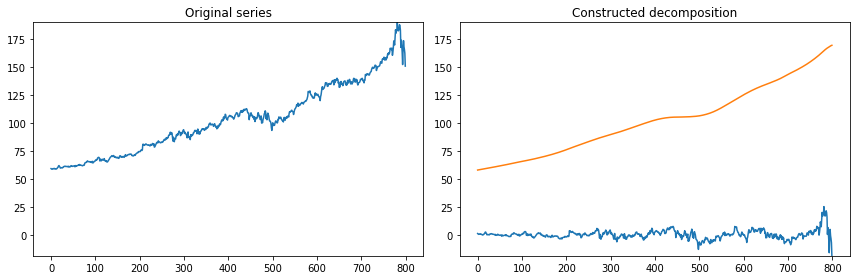

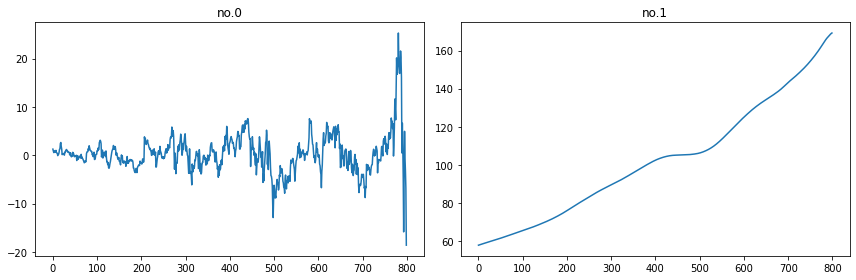

In [ ]:
sil_max = 0
n_clusters_max = 0
sils = []
for n_clusters in range(2,8):
    silhouette_avg, eig_val_clusters = eigen_value_grouping(d, x_el_series, L, n_clusters, eig_val=eig_val)
    if sil_max < silhouette_avg:
        sil_max = max(sil_max, silhouette_avg)
        n_clusters_max = n_clusters
    x_rec = np.zeros([n_clusters, len(x)])
    sils.append(silhouette_avg)
    for n in range(0, d):
        x_rec[eig_val_clusters[n],:] +=  x_el_series[n]

    print("n_clusters: " + str(n_clusters) + "; Sil. score: " + str(silhouette_avg))
#visual_matrix = np.zeros([L,L]])
#for k in range(0,d):
#    for j in range(0,d):
  #      if j<= k_min -1 and k<= k_min -1:
   #         visual_matrix[j,k] += 1
  #      if j>= k_min  and k>= k_min:
 #           visual_matrix[j,k] += 1

#plt.imshow(w_corr_matrix, interpolation='nearest', cmap=cm.Greys_r)
#plt.imshow(visual_matrix, interpolation='nearest', cmap=cm.ocean_r, alpha=0.5)
#plt.title("w-correlation matrix for the eigenfunctions with nonzero eigenvalue")
#plt.show()


print("n_clusters_max: " + str(n_clusters_max))
print("All silhouette_avg scores: " + str(sils))


for n_clusters in range(n_clusters_max,n_clusters_max+1):
    silhouette_avg, eig_val_clusters = eigen_value_grouping(d, x_el_series, L, n_clusters, eig_val=eig_val)
    if sil_max < silhouette_avg:
        sil_max = max(sil_max, silhouette_avg)
        n_clusters_max = n_clusters
    x_rec = np.zeros([n_clusters, len(x)])
    sils.append(silhouette_avg)
    for n in range(0, d):
        x_rec[eig_val_clusters[n],:] +=  x_el_series[n]

    print("n_clusters: " + str(n_clusters) + "; Sil. score: " + str(silhouette_avg))
#visual_matrix = np.zeros([L,L]])
#for k in range(0,d):
#    for j in range(0,d):
  #      if j<= k_min -1 and k<= k_min -1:
   #         visual_matrix[j,k] += 1
  #      if j>= k_min  and k>= k_min:
 #           visual_matrix[j,k] += 1

#plt.imshow(w_corr_matrix, interpolation='nearest', cmap=cm.Greys_r)
#plt.imshow(visual_matrix, interpolation='nearest', cmap=cm.ocean_r, alpha=0.5)
#plt.title("w-correlation matrix for the eigenfunctions with nonzero eigenvalue")
#plt.show()

    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    fig.tight_layout()

    axs[0].plot(x)
#axs[0].plot(x1_rec+x2_rec+x3_rec+x4_rec+x5_rec+x6_rec)
    axs[0].set_title('Original series')

    y_min = max(x)
    y_max = min(x)
    for n in range(0, n_clusters):
        y_min = min(y_min, min(x_rec[n,:]))
        y_max = max(y_max, max(x_rec[n,:]))
    axs[0].set_ylim(min(y_min, min(x)), max(y_max, max(x)))
    axs[1].set_ylim(min(y_min, min(x)), max(y_max, max(x)))
    for n in range(0, n_clusters):
        axs[1].plot(x_rec[n,:])
    axs[1].set_title('Constructed decomposition')
    fig.tight_layout()
    plt.show()

    fig, axs = plt.subplots(ncols=n_clusters, figsize=(12, 4))
    for n in range(0, n_clusters):
        axs[n].plot(x_rec[n,:])
        axs[n].set_title("no." + str(n))
    fig.tight_layout()
    plt.show()

In [ ]:
print(eig_val_clusters)

print(eig_val_clusters[0:1])

print(eig_val_clusters[1:3])

print(eig_val_clusters[3:9])

print(eig_val_clusters[9:16])

print(eig_val_clusters[16:32])

print(eig_val_clusters[32:len(eig_val_clusters)])

p = eig_val_clusters[0]
j_th = 1




[1 2 4 3 3 3 3 3 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1]
[2 4]
[3 3 3 3 3 5]
[5 5 5 5 5 5 5]
[5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
